In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import dip.network_vis as net_vis

In [2]:
num_layers = 2
channels = [1, 10, 10, 10, 1]
img_shape = (16, 16)
kernel_shape = (3, 3)
steps = 70
layer_inputs = {}
for l in range(num_layers):
    l_in = np.random.uniform(low=0, high=10, size=(steps, *img_shape, channels[l]))
    kernels = np.random.uniform(low=0, high=10, size=(steps, channels[l+1], *kernel_shape, channels[l]))
    l_da = xr.DataArray(l_in,    dims=('step', f'l{l}_y', f'l{l}_x', f'l{l}_c'))
    k_da = xr.DataArray(kernels, dims=('step', f'k{l}_k', f'k{l}_y', f'k{l}_x', f'l{l}_c'))
    layer_inputs[f'l{l}'] = l_da
    layer_inputs[f'k{l}'] = k_da

In [3]:
import pathlib
#ds = xr.Dataset(data_vars=layer_inputs)
ds = xr.open_dataset('../out/experiments/2/3/d_instrumentation.nc')
ds.min()
ds.quantile(0.95) - ds.max()


<xarray.Dataset>
Dimensions:         ()
Coordinates:
    quantile        float64 0.95
Data variables:
    layer_1_input   float64 -11.71
    layer_2_input   float64 -3.963
    layer_3_input   float64 -1.558
    layer_0_input   float64 -5.832
    layer_4_input   float64 -3.692
    layer_1_kernel  float64 -11.45
    layer_2_kernel  float64 -15.77
    layer_0_kernel  float64 -26.11
    layer_3_kernel  float64 -30.92

In [14]:
out_dir = '../out/experiments/2/2/network_vis'
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True) 
ds['layer_0_input'].sizes['l0_c']
ds.keys()
float(ds.quantile(0.05)['layer_1_input'])


-0.020120887458324438

(864, 432, 3)


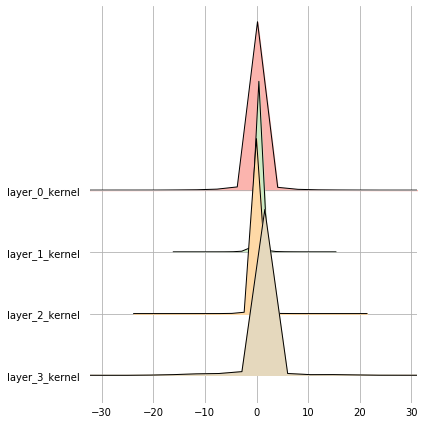

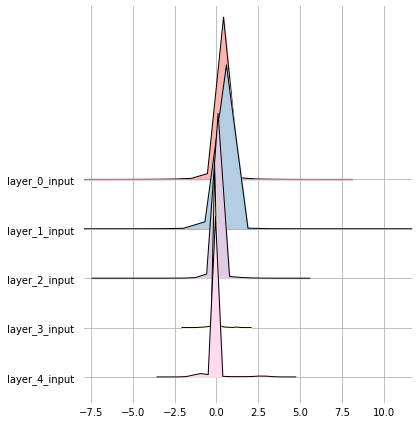

In [5]:
#net_vis.print_network(ds, out_dir)
#net_vis.print_network_step(ds, 0)
net_vis.network_density_plot(ds, '../out/experiments/2/2/network_vis/density.png')
net_vis.save_network_step_with_density(ds, 0, '../out/experiments/2/2/network_vis', '../out/experiments/2/2/network_vis/network_density.png')

(array([5.800000e+01, 7.790000e+02, 6.867000e+03, 1.511557e+06,
        1.494700e+04, 1.446000e+03, 2.960000e+02, 3.700000e+01,
        5.000000e+00, 8.000000e+00]),
 array([-6.669292  , -4.8300657 , -2.990839  , -1.1516125 ,  0.68761396,
         2.5268404 ,  4.366067  ,  6.2052937 ,  8.044519  ,  9.883746  ,
        11.722973  ], dtype=float32),
 <a list of 10 Patch objects>)

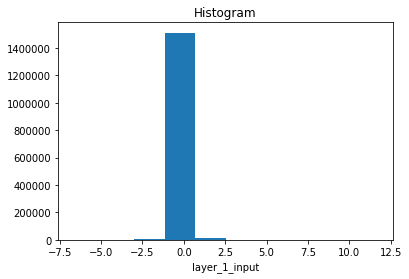

In [6]:
import joypy
import pandas as pd
set(ds['layer_0_kernel'].dims) - {'step'}
kernel_data = pd.DataFrame({k : ds[k].mean(tuple(set(ds[k].dims) - {'step'})).to_pandas() for k in net_vis.kernel_keys(ds)})
#layer_data = pd.DataFrame({l : ds[l].mean(tuple(set(ds[l].dims) - {'step'})).to_pandas() for l in net_vis.layer_in_keys(ds, exclude=[0])})
#layer_data = pd.DataFrame({l : 
#layer_data = pd.DataFrame({l : ds[l].values.flatten() for l in net_vis.layer_in_keys(ds)})
layer_data = {l : ds[l].values.flatten() for l in net_vis.layer_in_keys(ds)}
#vmax = layer_data.max()
#vmin = layer_data.min()
xr.plot.hist(ds['layer_1_input'])

In [7]:
cmap = matplotlib.cm.get_cmap('Pastel1')
#layer_data = {l: np.histogram(ds[l].values.flatten(), bins=20) for l in net_vis.layer_in_keys(ds) }
#hh, loc = layer_data['layer_1_input']

In [8]:
#vmax = layer_data.max().max()
#vmin = layer_data.min().min()
vmax = max(max(arr) for arr in layer_data.values())
vmin = min(min(arr) for arr in layer_data.values())


AttributeError: 'Rectangle' object has no property 'kind'

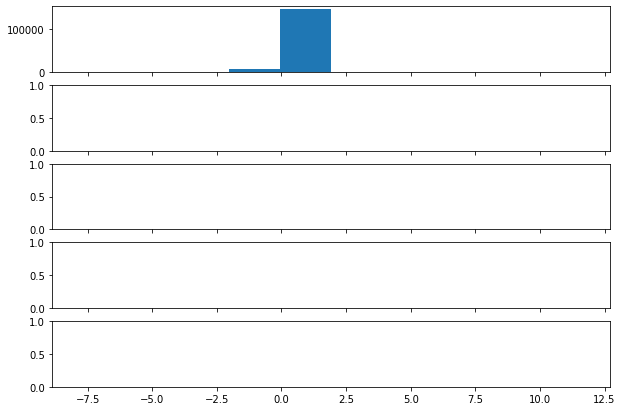

In [11]:
from mpl_toolkits.axes_grid1 import axes_size
fig, axes = joypy.joyplot(
    layer_data, 
    figsize=(10,7),
    colormap=matplotlib.cm.Pastel1,
    hist=True,
    kind='normalized_counts',
    bins=10,
    range_style='own',
    linewidth=1,
    ylim='max', # allow direct comparison. Share same y-limit between plots.
    overlap=0,#3,
    grid='both',
    x_range=(vmin, vmax))
#axes[0].vlines(vmin, ymin=0, ymax=10, linestyles='dotted')
#axes[0].vlines(vmax, ymin=0, ymax=10, linestyles='dotted') 
#divider = make_axes_locatable(axes[1])
#cax = divider.append_axes('top', size="5%", pad=0.05)
#cax.set_axis_off()
#cax.set_xlim(vmin, vmax)
#domain = np.linspace(vmin, vmax, 100)
#norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
#domain = np.vstack((domain, domain))
#cax.imshow(domain, norm=norm)

In [ ]:
import scipy
import scipy.signal
d = layer_data['layer_0_input']
hh,loc = scipy.histogram(d, range=(vmin, vmax), bins=100)
w= 0.1
kernel = scipy.stats.norm.pdf((loc[1:] + loc[:-1]) * 0.5, 0, w)
kde = scipy.signal.fftconvolve(hh, kernel, 'same')
plt.plot((loc[1:] + loc[:-1]*0.5), kde)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.api as sm
#ld = {k: sm.nonparametric.KDEUnivariate(l) for (k,v) in layer_data.items()}
ld0 = layer_data['layer_0_input']
dens = sm.nonparametric.KDEUnivariate(ld0)
dens.fit()
plt.plot(dens.cdf)
#for i in ld.values():
#    i.fit()
#ld = {k : v.cdf for (k,v) in ld.items()}

In [ ]:
fig, axes = joypy.joyplot(
    ld, 
    figsize=(10,10),
    hist=True,
    #colormap=matplotlib.cm.autumn_r,
    colormap=matplotlib.cm.Pastel1,
    range_style='own',
    linewidth=1,
    overlap=2.3,
    x_range=(vmin, vmax),
    grid='both',
    kind='values')
#divider = make_axes_locatable(axes[-1])
#cax = divider.append_axes('bottom', size="5%", pad=0.15)
#cax.set_axis_off()
#cax.set_xlim(vmin, vmax)
#domain = np.linspace(vmin, vmax, 100)
#norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
#domain = np.vstack((domain, domain, domain))
#cax.imshow(domain, norm=norm)